In [1]:
import torch 
from torch import optim
from torchvision.transforms import transforms as T
from torch import nn  
import model
from model import CNNtoRNN
from get_loaders import Flicker_Dataset, MyCollate
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np

c:\Users\user\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [2]:
transformation = T.Compose([
    T.Resize((224,224)),
    # T.CenterCrop((300,300)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_location = "Flicker8k/flickr8k"

dataset  = Flicker_Dataset(
    data_location+ "/images",
    data_location+"/captions.txt",
    transform=transformation,
    freq_threshold=3
)

pad_idx = dataset.vocab.stoi["<PAD>"]

loader = DataLoader(
        dataset=dataset,
        batch_size=16,
        shuffle=True,
        pin_memory=True,
        collate_fn=MyCollate(pad_idx),
        num_workers=6
    )


In [3]:
image, _ = dataset[7]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


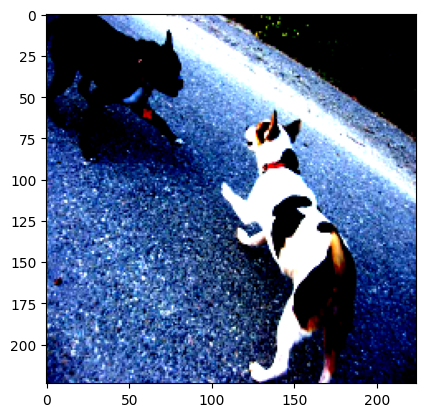

In [4]:
plt.imshow(np.array(image).transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


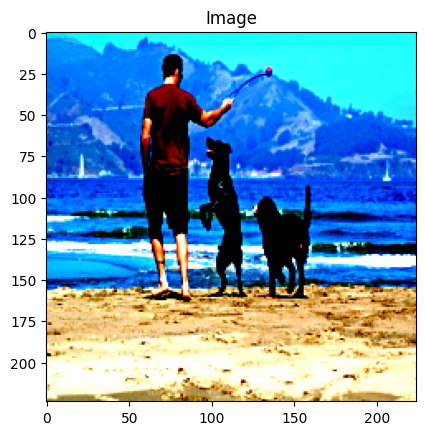

Token: tensor([ 1, 25, 29, 15, 97, 20, 84, 96,  5,  2])
Sentence:
['<SOS>', 'man', 'at', 'the', 'beach', 'with', 'two', 'dogs', '.', '<EOS>']


In [5]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
#generating the iterator from the dataloader

IMAGE, CAP = dataset[289]
show_image(IMAGE,"Image")
print("Token:",CAP)
print("Sentence:")
print([dataset.vocab.itos[token] for token in CAP.tolist()])

In [6]:
# from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters initialization
embed_size = 250
n_layers = 1
hidden_size = 256
vocab_size = len(dataset.vocab)
learning_rate = 0.0004
n_epochs = 1

# initialize the model, and loss function
# model = CNNtoRNN(embed_size=embed_size, n_layers=n_layers, vocabulary_size=vocab_size, hidden_size=hidden_size).to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>'])

model = CNNtoRNN(embed_size=embed_size, n_layers=n_layers, vocabulary_size=vocab_size, hidden_size=hidden_size).to(device)
m = torch.load('checkpoint.pth.tar')
model.load_state_dict(m['model'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(m['optimizer'])
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>'])
# # Writer will output to ./runs/ directory by default
# writer = SummaryWriter()


In [21]:
# import composer.functional as cf
# from composer import Trainer
# from composer.algorithms import ChannelsLast, CutMix, LabelSmoothing

# cf.apply_blurpool(model)
# cf.apply_squeeze_excite(model)


In [22]:



# accumulation_steps = 4
# running_loss=0

# for epoch in range(n_epochs):
#     for idx , (img, caption) in enumerate(loader):

#         img , caption = img.to(device), caption.to(device)

#         output = model(img, caption[:-1])
        
#         loss = criterion(output.reshape(-1, output.shape[2]), caption.reshape(-1))
        
#         # optimizer.zero_grad()
#         loss.backward(loss)
#         # optimizer.step()

#         if (idx+1) % accumulation_steps == 0:
#         # Update the model parameters
#             optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if (idx+1) % 100 == 0:
#             print('[Epoch %d, Batch %5d] loss: %.3f' % (epoch+1, idx+1, running_loss / 100))
#             running_loss = 0.0
#         else:
#             # Don't update the model parameters yet
#             optimizer.zero_grad()

    # print(f'Epoch {epoch} Correct Captions: {CAP}')
    # print(f'Epoch {epoch} output: {[dataset.vocab.itos[idx] for idx in model.caption_image(IMAGE, dataset.vocab)]}')
    


accumulation_steps = 4
running_loss = 0

for epoch in range(n_epochs):
    for idx, (img, caption) in enumerate(loader):

        img, caption = img.to(device), caption.to(device)

        output = model(img, caption[:-1])

        loss = criterion(output.reshape(-1, output.shape[2]), caption.reshape(-1))

        # Compute gradients
        loss /= accumulation_steps  # divide by accumulation steps
        loss.backward()

        # Update the model parameters every accumulation_steps iterations
        if (idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Print statistics
        running_loss += loss.item()
        if (idx + 1) % 100 == 0:
            print('[Epoch %d, Batch %5d] loss: %.3f' % (epoch + 1, idx + 1, running_loss / 100))
            running_loss = 0.0




[Epoch 1, Batch   100] loss: 0.516


KeyboardInterrupt: 

In [ ]:
# import torchvision.models as models
# efficientnet =  models.efficientnet_b3(weight= models.EfficientNet_B3_Weights.DEFAULT)
# print(efficientnet)

In [ ]:
model.caption_image(image=IMAGE.to(device), vocab=dataset.vocab, max_length=100)

['<SOS>',
 'a',
 'man',
 'is',
 'sitting',
 'on',
 'a',
 'bench',
 'and',
 'a',
 'woman',
 'in',
 'a',
 'white',
 'shirt',
 'and',
 'a',
 'pink',
 'shirt',
 '.',
 '<EOS>']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]


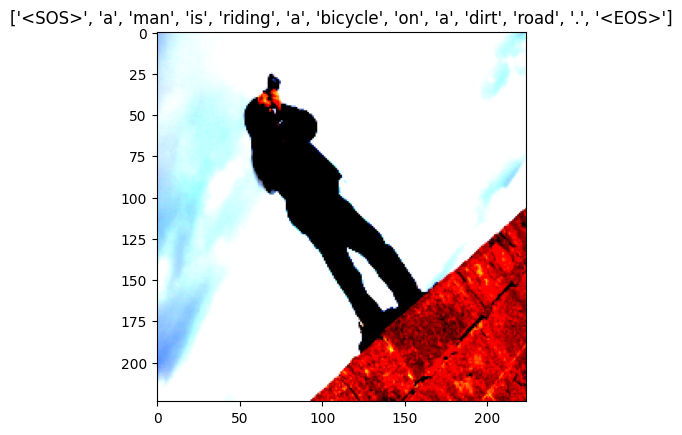

In [ ]:
# result = []

# with torch.no_grad():
#     x = model.CNN_Encoder(IMAGE.to(device).unsqueeze(0))
#     print(IMAGE.to(device).unsqueeze(0).size())
#     states = None
    
#     for i in range(200):
#         hiddens , states = model.RNN_Decoder.rnn(x, states)
#         output = model.RNN_Decoder.linear(hiddens.squeeze(0))
#         prediction = output.argmax(0)
#         result.append(prediction.item())
#         x = model.RNN_Decoder.embedding(prediction).unsqueeze(0)
#         print(result)
#         if dataset.vocab.itos[prediction.item()] == "<EOS>":
#             break
# result


result_caption = []
IMAGE , _ = dataset[np.random.randint(len(dataset))]
print(result_caption)
with torch.no_grad():
    x = IMAGE.to(device).unsqueeze(0)
    x = model.CNN_Encoder(x)
    states = None

    for _ in range(100):
        hiddens, states = model.RNN_Decoder.rnn(x, states)

        output = model.RNN_Decoder.linear(hiddens.squeeze(0))
        predicted = output.argmax()
        result_caption.append(predicted.item())
        x = model.RNN_Decoder.embedding(predicted).unsqueeze(0)

        if dataset.vocab.itos[predicted.item()] == "<EOS>":
            break
[dataset.vocab.itos[idx] for idx in result_caption]
show_image(IMAGE, [dataset.vocab.itos[idx] for idx in result_caption])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


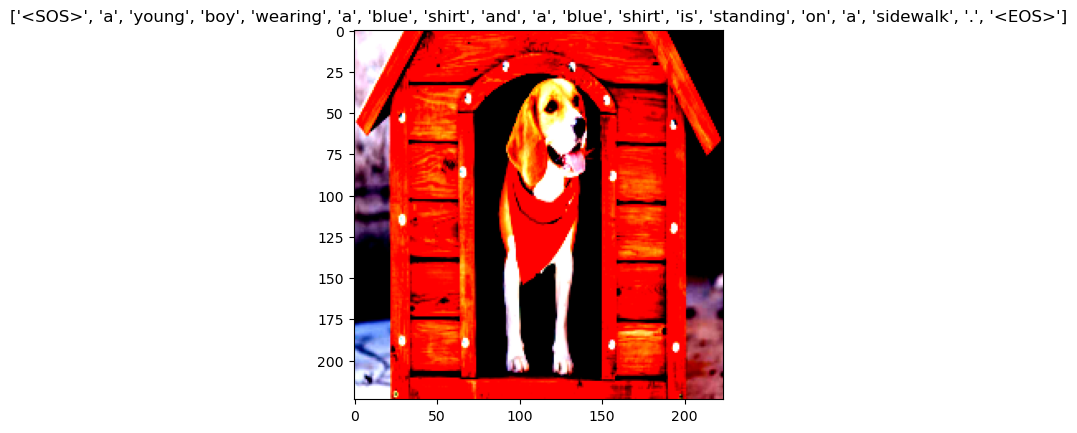

In [ ]:
from PIL import Image
image = Image.open('dog_in_house.jpg')
image = transformation(image)

# image , _= dataset[1000]

result_caption = []

with torch.no_grad():
    img = image.to(device).unsqueeze(0)
    x = model.CNN_Encoder(img)
    states = None

    for _ in range(200):
        hiddens, states = model.RNN_Decoder.rnn(x, states)

        output = model.RNN_Decoder.linear(hiddens.squeeze(0))
        predicted = output.argmax()
        result_caption.append(predicted.item())
        x = model.RNN_Decoder.embedding(predicted).unsqueeze(0)

        if dataset.vocab.itos[predicted.item()] == "<EOS>":
            break
[dataset.vocab.itos[idx] for idx in result_caption]
show_image(image.cpu(), [dataset.vocab.itos[idx] for idx in result_caption])

In [ ]:
torch.save({'model':model.state_dict(), 'optimizer':optimizer.state_dict()}, 'checkpoint.pth.tar')